# LSTM Stock Price Prediction

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
import yfinance as yf
import matplotlib.pyplot as plt

### Function to Fetch Stock Data

In [4]:
def get_stock_data(tickers, start_date='2019-12-20', interval='1d', period='5y'):
    data_dict = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, interval=interval, period=period)
        if not isinstance(data, pd.DataFrame) or data.empty:
            print(f"Warning: No valid data found for ticker {ticker}.")
            continue
        data_dict[ticker] = data
    return data_dict

### Data Preprocessing

In [5]:
def preprocess_data_daily(data, feature_column='Close', look_back=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[[feature_column]])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [6]:
def preprocess_data_weekly(data, feature_column='Close', look_back=60, prediction_horizon=7):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data[[feature_column]])

    X, y = [], []
    for i in range(look_back, len(data_scaled) - prediction_horizon):
        X.append(data_scaled[i-look_back:i, 0])
        y.append(data_scaled[i + prediction_horizon, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    return X_train, y_train, X_test, y_test, scaler


### Building the LSTM Model

In [7]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [8]:
tickers = ['^NDX']
data_dict = get_stock_data(tickers)
look_back = 60
epochs = 10
batch_size = 32
results = []
#tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'AMD', 'AMZN', 'NFLX', 'INTC', 'XOM', 'CVX', 'OXY', 'MRNA', 'PFE', 'BIIB', 'GME', 'AMC', 'BB', 'PLUG', 'PLTR', 'ROKU', 'ZM', 'SQ', 'PYPL', 'UBER', 'LYFT', 'T', 'VZ', 'TMUS', 'S', 'TM', 'F', 'GM', 'NIO', 'LI', 'XPEV', 'PBM', 'SRM', 'NTRP', 'ENTO', 'CRKN', 'JZXN', 'ABP']

In [20]:
data_dict

{'^NDX':                                    Open          High           Low  \
 Date                                                                  
 2019-12-20 00:00:00-05:00   8666.570312   8687.660156   8656.480469   
 2019-12-23 00:00:00-05:00   8703.059570   8710.900391   8690.150391   
 2019-12-24 00:00:00-05:00   8705.299805   8708.219727   8684.120117   
 2019-12-26 00:00:00-05:00   8717.950195   8778.330078   8716.030273   
 2019-12-27 00:00:00-05:00   8805.860352   8811.099609   8749.860352   
 ...                                 ...           ...           ...   
 2025-03-03 00:00:00-05:00  20989.580078  21073.800781  20279.500000   
 2025-03-04 00:00:00-05:00  20281.880859  20688.460938  20034.679688   
 2025-03-05 00:00:00-05:00  20363.220703  20688.720703  20182.570312   
 2025-03-06 00:00:00-05:00  20231.740234  20473.410156  19968.560547   
 2025-03-07 00:00:00-05:00  20015.599609  20253.216797  19736.806641   
 
                                   Close      Volume  

### Predicting Next Day Price

In [9]:
def predict_next_day_price(model, recent_data, scaler):
    recent_data_scaled = scaler.transform(recent_data)
    X_input = np.array([recent_data_scaled])
    X_input = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))
    predicted_scaled = model.predict(X_input)
    predicted_price = scaler.inverse_transform(predicted_scaled)
    return predicted_price[0, 0]

In [10]:
def predict_next_week_price(model, recent_data, scaler, look_back=60):
    predicted_prices = []
    
    recent_data_scaled = scaler.transform(recent_data)
    X_input = np.array([recent_data_scaled])
    X_input = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))

    for _ in range(7):  
        predicted_scaled = model.predict(X_input)
        predicted_price = scaler.inverse_transform(predicted_scaled)
        predicted_prices.append(predicted_price[0, 0])

        X_input = np.roll(X_input, -1, axis=1)
        X_input[0, -1, 0] = predicted_scaled  
    
    return predicted_prices


# PLOT


In [11]:
def plot_metrics(history, ticker):
    plt.figure(figsize=(25, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='orchid')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='purple')
    plt.title(f"{ticker} Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

--

training for next day pred

In [12]:
for ticker, data in data_dict.items():
    print(f"Processing data for {ticker}...")
    if not isinstance(data, pd.DataFrame) or data.empty:
        print(f"Skipping {ticker} due to invalid data.")
        continue
    
    X, y, scaler = preprocess_data_daily(data, look_back=look_back)   
    split = int(len(X) * 0.8)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    print(f"{ticker} training set size: {X_train.shape[0]}, testing set size: {X_test.shape[0]}")     
    model = build_lstm_model((X_train.shape[1], 1))
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=2)

Processing data for ^NDX...
^NDX training set size: 999, testing set size: 250
Epoch 1/10


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 - 2s - 74ms/step - loss: 0.0230 - val_loss: 0.0039
Epoch 2/10
32/32 - 1s - 17ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 3/10
32/32 - 1s - 17ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 4/10
32/32 - 1s - 17ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 5/10
32/32 - 1s - 17ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 6/10
32/32 - 1s - 17ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 7/10
32/32 - 1s - 17ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 8/10
32/32 - 1s - 17ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 9/10
32/32 - 1s - 17ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 10/10
32/32 - 1s - 17ms/step - loss: 0.0017 - val_loss: 0.0011


evaluating next day pred

In [21]:
for ticker, data in data_dict.items():
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)  
        rmse = np.sqrt(mse)  
        mape = mean_absolute_percentage_error(y_test, y_pred) * 100
         
        recent_data = data['Close'].values[-look_back:].reshape(-1, 1)
        next_day_price = predict_next_day_price(model, recent_data, scaler)

        results.append({
            'Next Day Price': next_day_price,
            'Ticker': ticker,
            'test MSE': mse,
            'R2': r2,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'Accuracy (%)': 100 - mape,
            
        })

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [22]:
results_df = pd.DataFrame(results)
print("\nSummary of results:")
print(results_df)


Summary of results:
   Next Day Price Ticker  test MSE       R2       MAE      RMSE      MAPE  \
0    20776.074219   ^NDX  0.001055  0.85727  0.026503  0.032473  3.160013   
1    20776.074219   ^NDX  0.001055  0.85727  0.026503  0.032473  3.160013   

   Accuracy (%)  
0     96.839987  
1     96.839987  


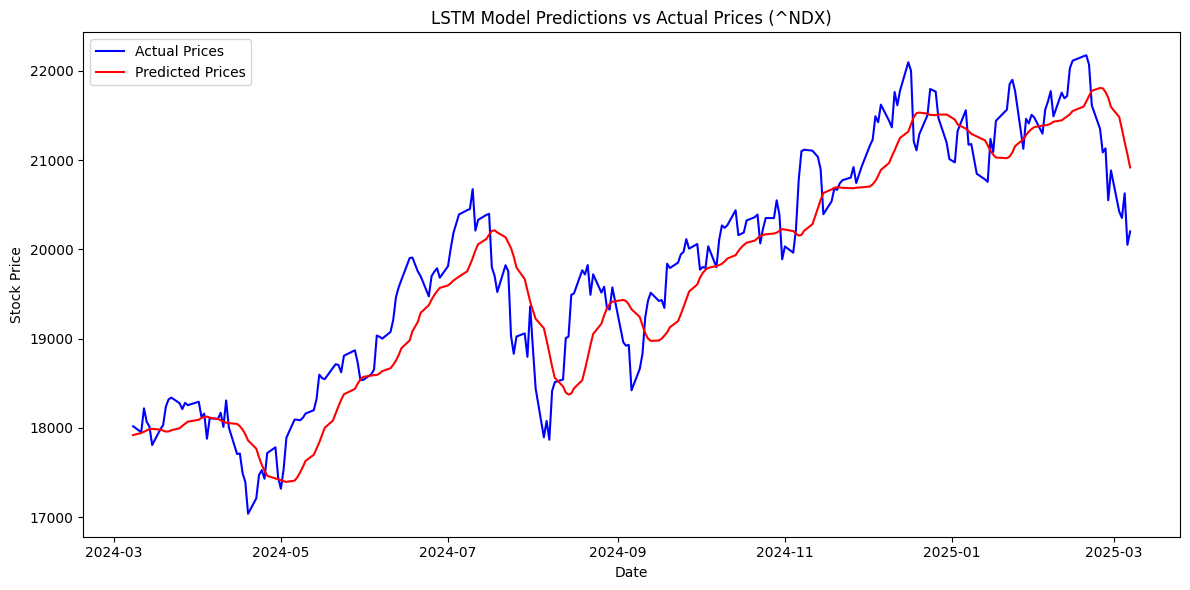

In [25]:
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_inverse, label='Actual Prices', color='blue') 
plt.plot(data.index[-len(y_pred):], y_pred_inverse, label='Predicted Prices', color='red') 
plt.title(f'LSTM Model Predictions vs Actual Prices ({ticker})')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show()


Epoch 1/10


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 - 2s - 47ms/step - loss: 0.0215
Epoch 2/10
40/40 - 1s - 15ms/step - loss: 0.0041
Epoch 3/10
40/40 - 1s - 15ms/step - loss: 0.0033
Epoch 4/10
40/40 - 1s - 15ms/step - loss: 0.0029
Epoch 5/10
40/40 - 1s - 15ms/step - loss: 0.0028
Epoch 6/10
40/40 - 1s - 15ms/step - loss: 0.0026
Epoch 7/10
40/40 - 1s - 15ms/step - loss: 0.0025
Epoch 8/10
40/40 - 1s - 15ms/step - loss: 0.0023
Epoch 9/10
40/40 - 1s - 15ms/step - loss: 0.0026
Epoch 10/10
40/40 - 1s - 15ms/step - loss: 0.0021
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


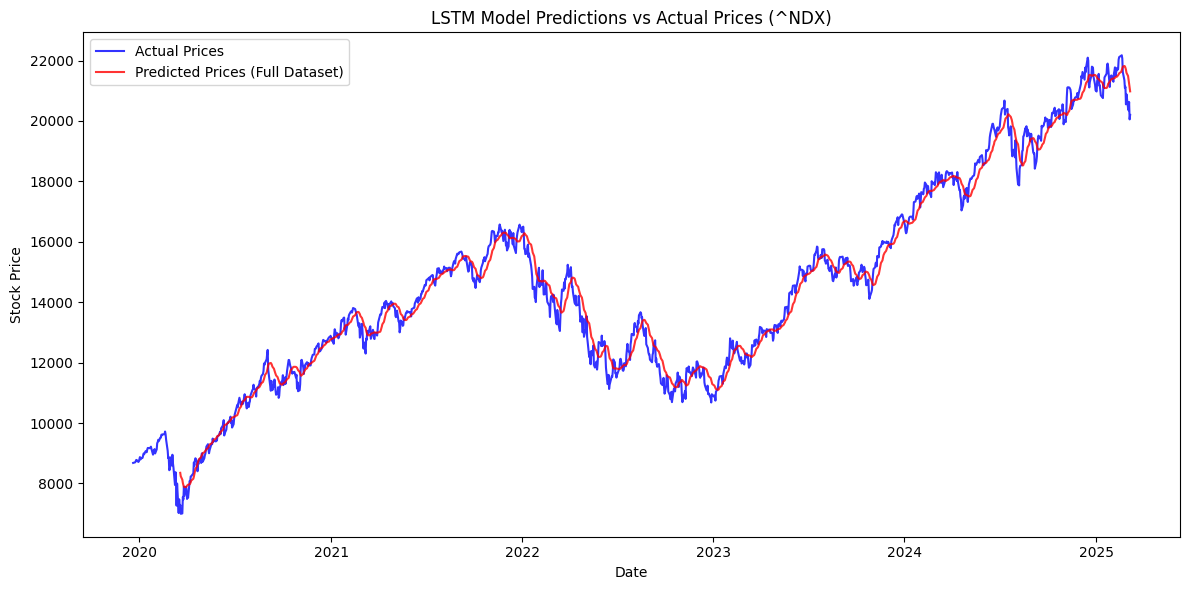

In [26]:
# Prepare the full dataset for prediction
X_full, y_full, scaler = preprocess_data_daily(data, look_back=look_back)

# Train the model on the full dataset
model_full = build_lstm_model((X_full.shape[1], 1))
history_full = model_full.fit(X_full, y_full, batch_size=batch_size, epochs=epochs, verbose=2)

# Predict for the entire dataset
y_pred_full = model_full.predict(X_full)

# Inverse transform the predictions and actual values
y_pred_full_inverse = scaler.inverse_transform(y_pred_full)
y_full_inverse = scaler.inverse_transform(y_full.reshape(-1, 1))

# Create a placeholder array to align predictions with the full dataset
full_predicted_prices = np.full((len(data),), np.nan)
full_predicted_prices[look_back:] = y_pred_full_inverse.flatten()

# Plot the full predictions vs. actual prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Actual Prices', color='blue', alpha=0.8)
plt.plot(data.index, full_predicted_prices, label='Predicted Prices (Full Dataset)', color='red', alpha=0.8)
plt.title(f'LSTM Model Predictions vs Actual Prices ({ticker})')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
mse_full = mean_squared_error(y_full_inverse, y_pred_full_inverse)
r2_full = r2_score(y_full_inverse, y_pred_full_inverse)
mae_full = mean_absolute_error(y_full_inverse, y_pred_full_inverse)
rmse_full = np.sqrt(mse_full)
mape_full = np.mean(np.abs((y_full_inverse - y_pred_full_inverse) / y_full_inverse)) * 100  # Percentage

# Print evaluation metrics
print("Evaluation Metrics for Full Dataset Predictions:")
print(f"Mean Squared Error (MSE): {mse_full:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_full:.4f}")
print(f"Mean Absolute Error (MAE): {mae_full:.4f}")
print(f"R² Score: {r2_full:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_full:.2f}%")
print(f"Accuracy (%): {100 - mape_full:.2f}%")

Evaluation Metrics for Full Dataset Predictions:
Mean Squared Error (MSE): 163819.2833
Root Mean Squared Error (RMSE): 404.7459
Mean Absolute Error (MAE): 321.2142
R² Score: 0.9847
Mean Absolute Percentage Error (MAPE): 2.27%
Accuracy (%): 97.73%


plotting next day loss

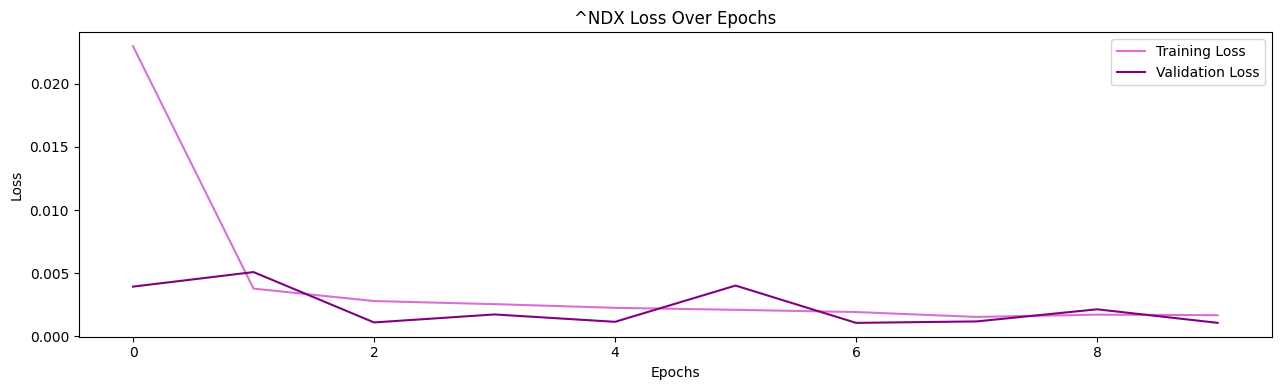

In [18]:
for ticker, data in data_dict.items():
    plot_metrics(history, ticker)

training week pred

Processing weekly data for ^NDX...
Epoch 1/10


c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 - 2s - 223ms/step - loss: 0.1743
Epoch 2/10
7/7 - 0s - 18ms/step - loss: 0.0364
Epoch 3/10
7/7 - 0s - 18ms/step - loss: 0.0230
Epoch 4/10
7/7 - 0s - 18ms/step - loss: 0.0154
Epoch 5/10
7/7 - 0s - 18ms/step - loss: 0.0144
Epoch 6/10
7/7 - 0s - 18ms/step - loss: 0.0115
Epoch 7/10
7/7 - 0s - 18ms/step - loss: 0.0100
Epoch 8/10
7/7 - 0s - 17ms/step - loss: 0.0099
Epoch 9/10
7/7 - 0s - 17ms/step - loss: 0.0078
Epoch 10/10
7/7 - 0s - 17ms/step - loss: 0.0087
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


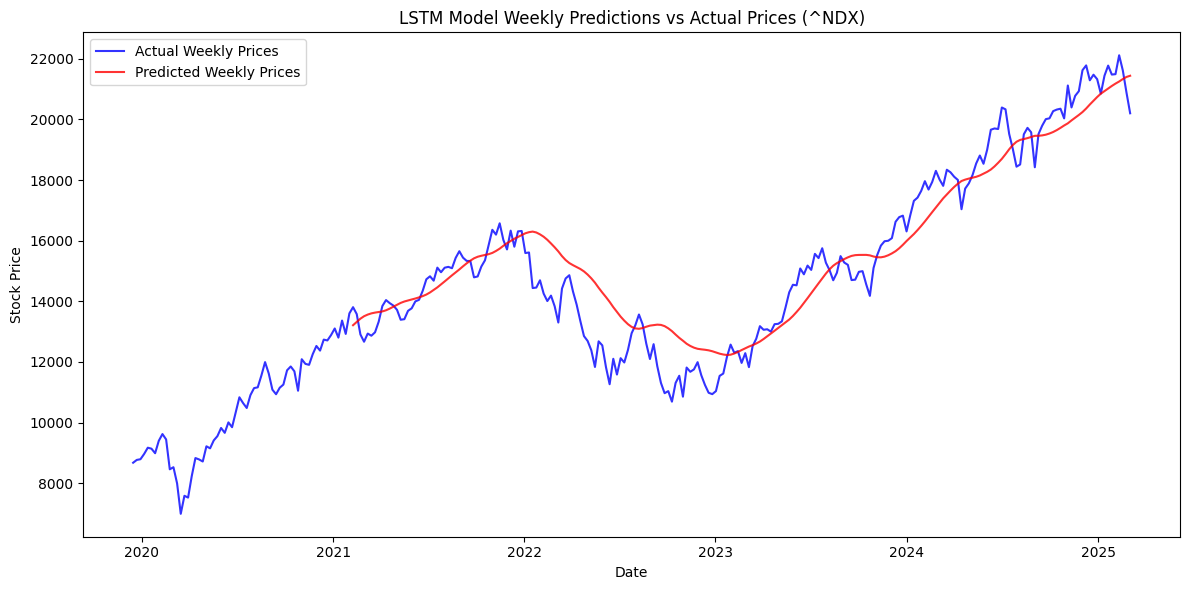


Summary of Weekly Results:
  Ticker     Weekly MSE  Weekly R2  Weekly MAE  Weekly RMSE  Weekly MAPE  \
0   ^NDX  940492.814289   0.894561  763.396553   969.790088     5.328448   

   Weekly Accuracy (%)  
0            94.671552  


In [19]:
# Get weekly stock data
data_weekly_dict = get_stock_data(tickers, interval='1wk')

# Initialize results for weekly predictions
weekly_results = []

for ticker, data in data_weekly_dict.items():
    print(f"Processing weekly data for {ticker}...")

    if not isinstance(data, pd.DataFrame) or data.empty:
        print(f"Skipping {ticker} due to invalid data.")
        continue

    # Preprocess the weekly data
    X_weekly, y_weekly, scaler_weekly = preprocess_data_daily(data, look_back=look_back)

    # Train on the weekly data
    model_weekly = build_lstm_model((X_weekly.shape[1], 1))
    history_weekly = model_weekly.fit(X_weekly, y_weekly, batch_size=batch_size, epochs=epochs, verbose=2)

    # Predict weekly prices
    y_weekly_pred = model_weekly.predict(X_weekly)

    # Inverse transform predictions and actual values
    y_weekly_pred_inverse = scaler_weekly.inverse_transform(y_weekly_pred)
    y_weekly_inverse = scaler_weekly.inverse_transform(y_weekly.reshape(-1, 1))

    # Calculate evaluation metrics for weekly predictions
    mse_weekly = mean_squared_error(y_weekly_inverse, y_weekly_pred_inverse)
    r2_weekly = r2_score(y_weekly_inverse, y_weekly_pred_inverse)
    mae_weekly = mean_absolute_error(y_weekly_inverse, y_weekly_pred_inverse)
    rmse_weekly = np.sqrt(mse_weekly)
    mape_weekly = np.mean(np.abs((y_weekly_inverse - y_weekly_pred_inverse) / y_weekly_inverse)) * 100

    # Add to results
    weekly_results.append({
        'Ticker': ticker,
        'Weekly MSE': mse_weekly,
        'Weekly R2': r2_weekly,
        'Weekly MAE': mae_weekly,
        'Weekly RMSE': rmse_weekly,
        'Weekly MAPE': mape_weekly,
        'Weekly Accuracy (%)': 100 - mape_weekly,
    })

    # Plot weekly predictions
    full_weekly_predicted_prices = np.full((len(data),), np.nan)
    full_weekly_predicted_prices[look_back:] = y_weekly_pred_inverse.flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Actual Weekly Prices', color='blue', alpha=0.8)
    plt.plot(data.index, full_weekly_predicted_prices, label='Predicted Weekly Prices', color='red', alpha=0.8)
    plt.title(f'LSTM Model Weekly Predictions vs Actual Prices ({ticker})')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create a DataFrame for weekly results
weekly_results_df = pd.DataFrame(weekly_results)
print("\nSummary of Weekly Results:")
print(weekly_results_df)
